# Introduction

https://www.kaggle.com/mlg-ulb/creditcardfraud

## Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Data
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

<h1> EDA

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [147]:
filepath = "data/creditcard.csv"
df = pd.read_csv(filepath, engine="python")

In [148]:
df.shape

(284807, 31)

In [149]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


No handles with labels found to put in legend.


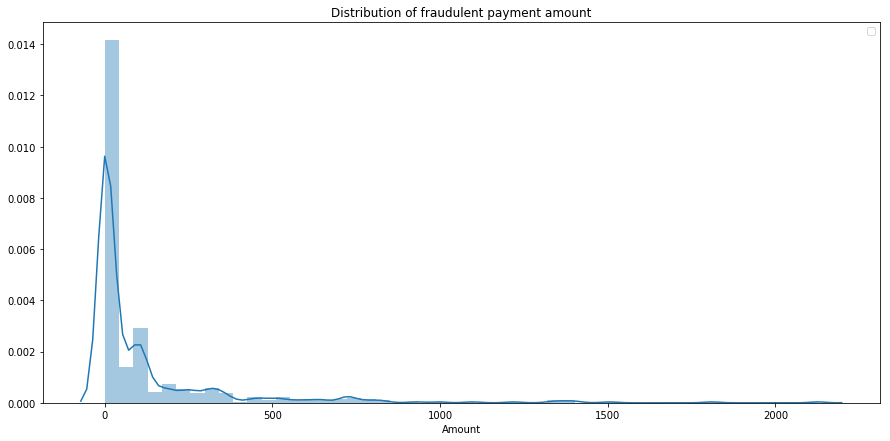

In [150]:
plt.figure(figsize=(15,7))
sns.distplot(df[df["Class"]==1]["Amount"])
plt.title("Distribution of fraudulent payment amount")
plt.legend()
plt.show()


<h1> Features preparation

We would like to get more out of the Time feature, to be able to analyze if the time has a influence on the fraudulent payment.

<h2> Time feature creation

In [151]:
def time_decompo(x):
    nb_min, nb_secs = x//60, x%60
    nb_hour, nb_mins = nb_min//60, nb_min%60
    nb_day, nb_hours = nb_hour//24, nb_hour%24
    return nb_day, nb_hours, nb_mins, nb_secs

In [152]:
df.apply(lambda x: [1, 2], axis=1)
df["Day"] = df["Time"].apply(lambda x: time_decompo(x)[0])
df["Hour"] = df["Time"].apply(lambda x: time_decompo(x)[1])
df["Min"] = df["Time"].apply(lambda x: time_decompo(x)[2])
df["Sec"] = df["Time"].apply(lambda x: time_decompo(x)[3])

<h2> Data viz with the new time features

No handles with labels found to put in legend.


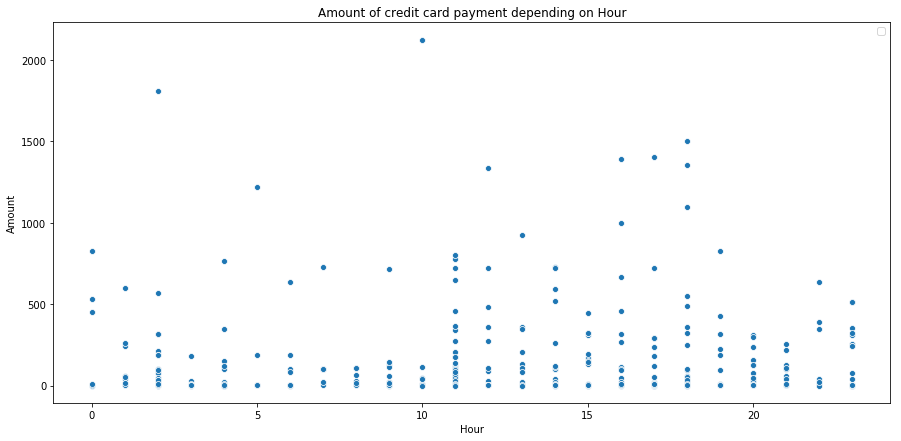

In [153]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=df[df["Class"]==1]["Hour"], y=df[df["Class"]==1]["Amount"])
plt.title("Amount of credit card payment depending on Hour")
plt.legend()
plt.show()

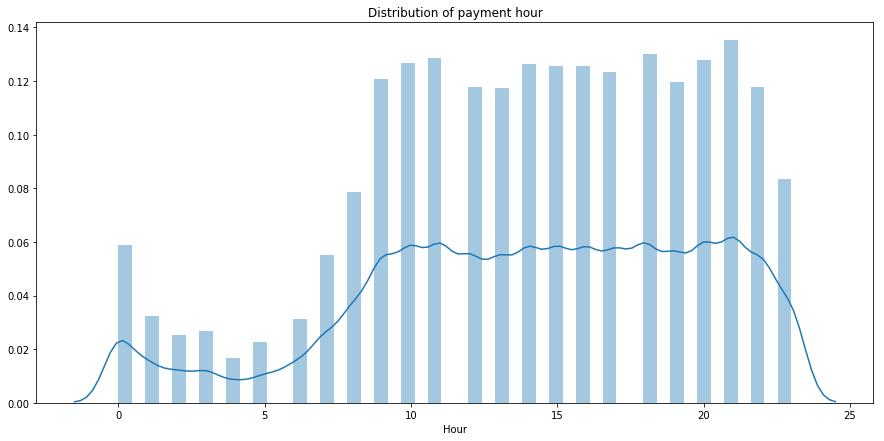

In [154]:
plt.figure(figsize=(15,7))
sns.distplot(df["Hour"])
plt.title("Distribution of payment hour")
plt.show()

Base on that distribution we can assess H=0 -> H=22H

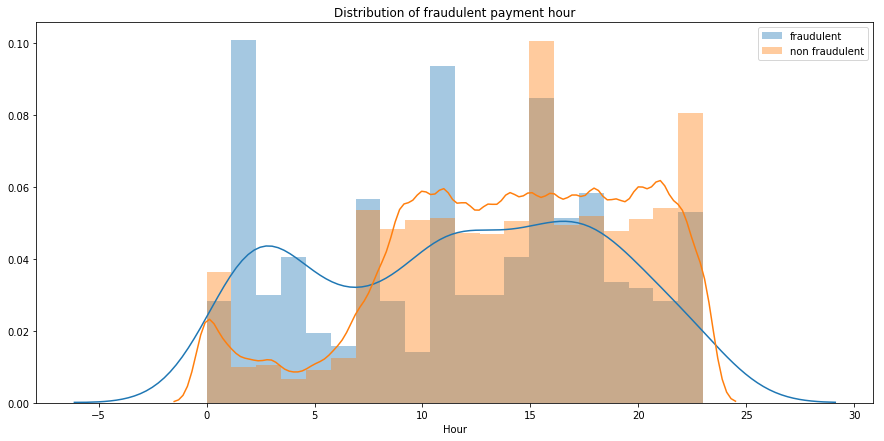

In [155]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(hspace=0.4)

sns.distplot(df[df["Class"]==1]["Hour"], label="fraudulent", bins=20)
sns.distplot(df[df["Class"]==0]["Hour"], label="non fraudulent", bins=20)
plt.title("Distribution of fraudulent payment hour")

plt.legend()
plt.show()

We can clearly noticed that there are more fraudulent payment during the night, It could be interresting to categorize by day and night the hour

In [156]:
def night_time(x):
    if x < 7 or x > 0:
        return 1
    else:
        return 0

In [157]:
df["NightTime"] = df["Hour"].apply(lambda x: night_time(x)) 

In [158]:
df.shape

(284807, 36)

<h2> Features selection

In [159]:
column_drop = ["Day", "Min", "Sec"]
df = df.drop(column_drop, axis=1)

<h2> Sampling

In [160]:
df_sample = df.sample(frac=1, replace=False, random_state=0)

In [161]:
df_sample.shape

(284807, 33)

In [162]:
ratio = df["Class"].sum()/df.shape[0]
print(f"Ratio of Class 1 in df: {round(ratio*100, 3)} %")
ratio = df_sample["Class"].sum()/df_sample.shape[0]
print(f"Ratio of Class 1 in df_sample: {round(ratio*100, 3)} %")

Ratio of Class 1 in df: 0.173 %
Ratio of Class 1 in df_sample: 0.173 %


<h2> Split of X_train, X_test

In [163]:
y = df_sample["Class"]
X = df_sample.drop("Class", axis=1)

In [164]:
X.shape

(284807, 32)

In [165]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [166]:
print(f"Ratio of Class 1 in y_train: {round((y_train.sum()/len(y_train))*100, 2)} %")
print(f"Ratio of Class 1 in y_test: {round((y_test.sum()/len(y_test))*100, 2)} %")

Ratio of Class 1 in y_train: 0.17 %
Ratio of Class 1 in y_test: 0.18 %


<h2> Scalling of data

We can not scalled over the full X, otherwise we would cheet by looking over X_test data

In [186]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X=X_train)

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [187]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X=X_test)

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


<h1> Imbalance data

<h2> Undersampling

In [188]:
from imblearn.under_sampling import RandomUnderSampler

In [189]:
rus = RandomUnderSampler(sampling_strategy='auto', return_indices=False, random_state=0, replacement=False, ratio=0.01)

In [190]:
X_undersamp, y_undersamp = rus.fit_resample(X_train_scaled, y_train)
X_undersamp.shape, y_undersamp.shape

((34037, 32), (34037,))

In [191]:
print(f"Ratio of Class 1 in y_undersamp: {round((y_undersamp.sum()/len(y_undersamp))*100, 2)} %")

Ratio of Class 1 in y_undersamp: 0.99 %


<h2> Oversampling (SMOTE)

In [192]:
from imblearn import over_sampling
smote = over_sampling.SMOTE(k_neighbors=5, ratio=0.01, random_state=0)

In [193]:
X_oversamp, y_oversamp = smote.fit_resample(X_train_scaled, y_train)
X_oversamp.shape, y_oversamp.shape

((201017, 32), (201017,))

In [194]:
print(f"Ratio of Class 1 in y_oversamp: {round((y_oversamp.sum()/len(y_oversamp))*100, 2)} %")

Ratio of Class 1 in y_oversamp: 0.99 %


<h1> Supervised Classification Model

In [195]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, f1_score, classification_report

<h2> Logistic Regression

In [196]:
from sklearn.linear_model import LogisticRegression

<h3> Raw data

In [197]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_score_lr = lr.predict_proba(X_test_scaled)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr[:,1])
roc_auc = auc(fpr_lr, tpr_lr)
roc_auc

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.973907005031907

In [198]:
y_pred = np.round(y_score_lr[:,1], 0)
print(int(y_pred.sum()), "transactions classified as fraudulent out of", y_test.sum())

105 transactions classified as fraudulent out of 155


<h3> Undersampling

In [199]:
lr = LogisticRegression()
lr.fit(X_undersamp, y_undersamp)
y_score_lr_u = lr.predict_proba(X_test_scaled)
fpr_lr_u, tpr_lr_u, _ = roc_curve(y_test, y_score_lr_u[:,1])
roc_auc = auc(fpr_lr_u, tpr_lr_u)
roc_auc

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9773968882662463

In [200]:
y_pred = np.round(y_score_lr_u[:,1], 0)
print(int(y_pred.sum()), "transactions classified as fraudulent out of", y_test.sum())

169 transactions classified as fraudulent out of 155


<h3> Oversampling

In [201]:
lr = LogisticRegression()
lr.fit(X_oversamp, y_oversamp)
y_score_lr_o = lr.predict_proba(X_test_scaled)
fpr_lr_o, tpr_lr_o, _ = roc_curve(y_test, y_score_lr_o[:,1])
roc_auc = auc(fpr_lr_o, tpr_lr_o)
roc_auc

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9742421881382548

In [202]:
y_pred = np.round(y_score_lr_o[:,1], 0)
print(int(y_pred.sum()), "transactions classified as fraudulent out of", y_test.sum())

150 transactions classified as fraudulent out of 155


<h3> Comparison

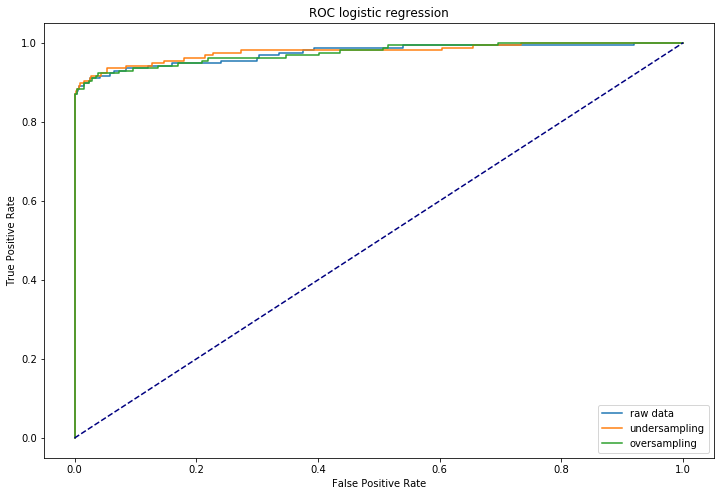

In [203]:
plt.figure(figsize=(12,8))

plt.plot(fpr_lr, tpr_lr, label='raw data')
plt.plot(fpr_lr_u, tpr_lr_u, label='undersampling')
plt.plot(fpr_lr_o, tpr_lr_o, label='oversampling')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC logistic regression')
plt.legend(loc="lower right")
plt.show()

-> Best Model: LR with Undersampling

In [204]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85288
           1       0.80      0.77      0.79       155

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.90      0.89      0.89     85443
weighted avg       1.00      1.00      1.00     85443



<h2> XG Boost

In [205]:
import xgboost as xgb

<h3> Raw data

In [206]:
xg = xgb.XGBClassifier()
xg.fit(X_train_scaled, y_train)
y_score_xg = xg.predict_proba(X_test_scaled)
fpr_xg, tpr_xg, _ = roc_curve(y_test, y_score_xg[:,1])
roc_auc = auc(fpr_xg, tpr_xg)
roc_auc

0.9805995851626822

In [207]:
y_pred = np.round(y_score_xg[:,1], 0)
print(int(y_pred.sum()), "transactions classified as fraudulent out of", y_test.sum())

131 transactions classified as fraudulent out of 155


<h3> Undersampling

In [208]:
xg = xgb.XGBClassifier()
xg.fit(X_undersamp, y_undersamp)
y_score_xg_u = xg.predict_proba(X_test_scaled)
fpr_xg_u, tpr_xg_u, _ = roc_curve(y_test, y_score_xg_u[:,1])
roc_auc = auc(fpr_xg_u, tpr_xg_u)
roc_auc

0.9825965003585575

In [209]:
y_pred = np.round(y_score_xg_u[:,1], 0)
print(int(y_pred.sum()), "transactions classified as fraudulent out of", y_test.sum())

169 transactions classified as fraudulent out of 155


<h3> Oversampling

In [210]:
xg = xgb.XGBClassifier()
xg.fit(X_oversamp, y_oversamp)
y_score_xg_o = xg.predict_proba(X_test_scaled)
fpr_xg_o, tpr_xg_o, _ = roc_curve(y_test, y_score_xg_o[:,1])
roc_auc = auc(fpr_xg_o, tpr_xg_o)
roc_auc

0.9804081654265925

In [211]:
y_pred = np.round(y_score_xg_o[:,1], 0)
print(int(y_pred.sum()), "transactions classified as fraudulent out of", y_test.sum())

152 transactions classified as fraudulent out of 155


<h3> Comparison

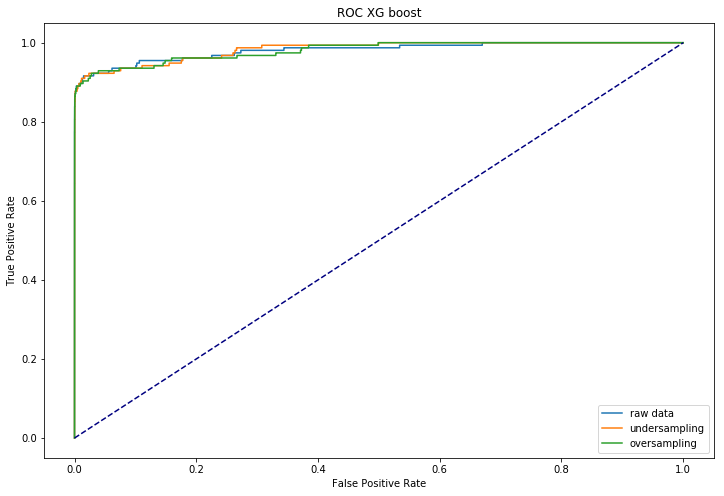

In [212]:
plt.figure(figsize=(12,8))

plt.plot(fpr_xg, tpr_xg, label='raw data')
plt.plot(fpr_xg_u, tpr_xg_u, label='undersampling')
plt.plot(fpr_xg_o, tpr_xg_o, label='oversampling')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC XG boost')
plt.legend(loc="lower right")
plt.show()

-> Best Model: LR with Raw data

<h2> LGBM

In [398]:
import lightgbm as lgb

<h3> Raw data

In [399]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train_scaled, y_train)
y_score_lg = lgbm.predict_proba(X_test_scaled)
fpr_lg, tpr_lg, _ = roc_curve(y_test, y_score_lg[:,1])
roc_auc = auc(fpr_lg, tpr_lg)
roc_auc

0.6412328172325419

In [400]:
y_pred = np.round(y_score_lg[:,1], 0)
print(int(y_pred.sum()), "transactions classified as fraudulent out of", y_test.sum())

713 transactions classified as fraudulent out of 155


<h3> Undersampling

In [401]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_undersamp, y_undersamp)
y_score_lg_u = lgbm.predict_proba(X_test_scaled)
fpr_lg_u, tpr_lg_u, _ = roc_curve(y_test, y_score_lg_u[:,1])
roc_auc = auc(fpr_lg_u, tpr_lg_u)
roc_auc

0.9818412604276667

In [402]:
y_pred = np.round(y_score_lg_u[:,1], 0)
print(int(y_pred.sum()), "transactions classified as fraudulent out of", y_test.sum())

170 transactions classified as fraudulent out of 155


<h3> Oversampling

In [403]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_oversamp, y_oversamp)
y_score_lg_o = lgbm.predict_proba(X_test_scaled)
fpr_lg_o, tpr_lg_o, _ = roc_curve(y_test, y_score_lg_o[:,1])
roc_auc = auc(fpr_lg_o, tpr_lg_o)
roc_auc

0.9792781800412115

In [404]:
y_pred = np.round(y_score_lg_o[:,1], 0)
print(int(y_pred.sum()), "transactions classified as fraudulent out of", y_test.sum())

145 transactions classified as fraudulent out of 155


<h3> Comparison

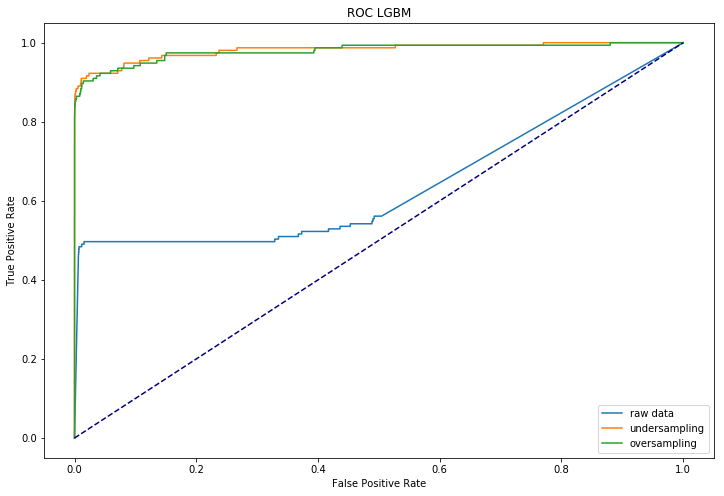

In [405]:
plt.figure(figsize=(12,8))

plt.plot(fpr_lg, tpr_lg, label='raw data')
plt.plot(fpr_lg_u, tpr_lg_u, label='undersampling')
plt.plot(fpr_lg_o, tpr_lg_o, label='oversampling')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC LGBM')
plt.legend(loc="lower right")
plt.show()

-> Best Model: LR with Oversampling

<h1> Anomaly detection model (Unsupervised)

- Ratio of Class 1 in y: 0.17 %
- Ratio of Class 1 in y_undersamp: 0.99 %
- Ratio of Class 1 in y_oversamp: 0.99 %

In [221]:
X_train_inliers = X_train_scaled[y_train==0]
X_train_inliers.shape

(199027, 32)

In [222]:
X_test_scaled.shape

(85443, 32)

<h2> Gaussian distribution based

In [223]:
from sklearn.covariance import EllipticEnvelope

In [224]:
G = EllipticEnvelope(random_state=0)

In [225]:
G.fit(X_train_inliers)
y_predG = G.predict(X_test_scaled)

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/covariance/robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


In [226]:
#y_predG = G.fit_predict(X_test)

In [227]:
# predict returns 1 for an inlier and -1 for an outlier
y_predG[y_predG == 1] = 0
y_predG[y_predG == -1] = 1

In [228]:
print(classification_report(y_test, y_predG))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     85288
           1       0.02      0.87      0.03       155

   micro avg       0.91      0.91      0.91     85443
   macro avg       0.51      0.89      0.49     85443
weighted avg       1.00      0.91      0.95     85443



In [229]:
print(y_predG.sum(), "transactions classified as fraudulent out of", y_test.sum())

7935 transactions classified as fraudulent out of 155


In [230]:
y_score_g = -G.score_samples(X_test_scaled)
fpr_G, tpr_G, _ = roc_curve(y_test, y_score_g)
roc_auc = auc(fpr_G, tpr_G)
roc_auc

0.921240442251075

<h2> Local Outlier Factor (LOF)

!!! LOF takes a long time to compute.

In [231]:
from sklearn.neighbors import LocalOutlierFactor

In [232]:
LOF = LocalOutlierFactor(contamination="auto", novelty=True) 

In [233]:
#LOF.fit(X_train_inliers)
#y_predLOF = LOF.predict(X_test_scaled) #assign novelty to True

In [234]:
y_predLOF[y_predLOF == 1] = 0
y_predLOF[y_predLOF == -1] = 1

NameError: name 'y_predLOF' is not defined

In [ ]:
n_errors = (y_predLOF != y_test).sum()
X_scores = LOF.negative_outlier_factor_
n_errors, LOF.offset_

In [ ]:
print(classification_report(y_test, y_predLOF))

In [ ]:
print(y_predLOF.sum(), "transactions classified as fraudulent out of", y_test.sum())

In [ ]:
y_score_lof = -LOF.score_samples(X_test_scaled)
fpr_LOF, tpr_LOF, _ = roc_curve(y_test, y_score_lof)
roc_auc = auc(fpr_LOF, tpr_LOF)
roc_auc

<h2> Isolation Forest

In [235]:
from sklearn.ensemble import IsolationForest

In [236]:
IF = IsolationForest(n_estimators=100, contamination="auto", behaviour="new", random_state=0)
IF.fit(X_train_inliers)
y_predIF = IF.predict(X_test_scaled)

In [237]:
#y_predIF = IF.fit_predict(X_test)

In [238]:
y_predIF[y_predIF == 1] = 0
y_predIF[y_predIF == -1] = 1

In [239]:
print(classification_report(y_test, y_predIF))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85288
           1       0.05      0.81      0.09       155

   micro avg       0.97      0.97      0.97     85443
   macro avg       0.52      0.89      0.54     85443
weighted avg       1.00      0.97      0.98     85443



In [240]:
print(y_predIF.sum(), "transactions classified as fraudulent out of", y_test.sum())

2642 transactions classified as fraudulent out of 155


In [241]:
y_score_if = -IF.score_samples(X_test_scaled)
fpr_IF, tpr_IF, _ = roc_curve(y_test, y_score_if)
roc_auc = auc(fpr_IF, tpr_IF)
roc_auc

0.9507023640583254

<h2> Comparison

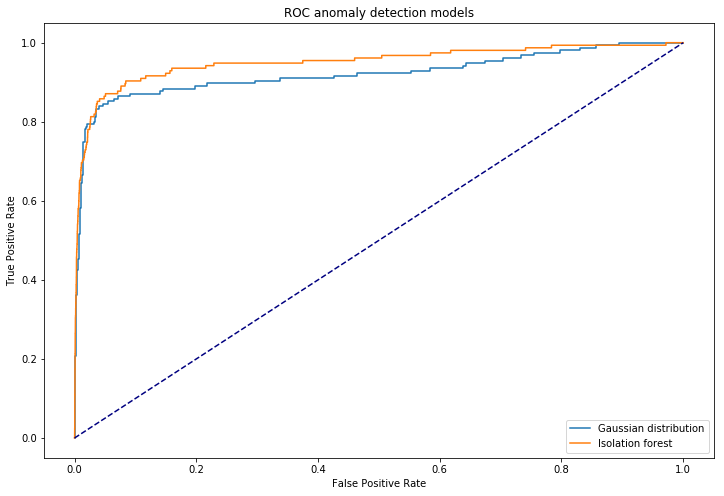

In [242]:
plt.figure(figsize=(12,8))

plt.plot(fpr_G, tpr_G, label='Gaussian distribution')
#plt.plot(fpr_LOF, tpr_LOF, label='Local Outlier Factor')
plt.plot(fpr_IF, tpr_IF, label='Isolation forest')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC anomaly detection models')
plt.legend(loc="lower right")
plt.show()

<h1> Comparison of both methods

<h2> ROC AUC

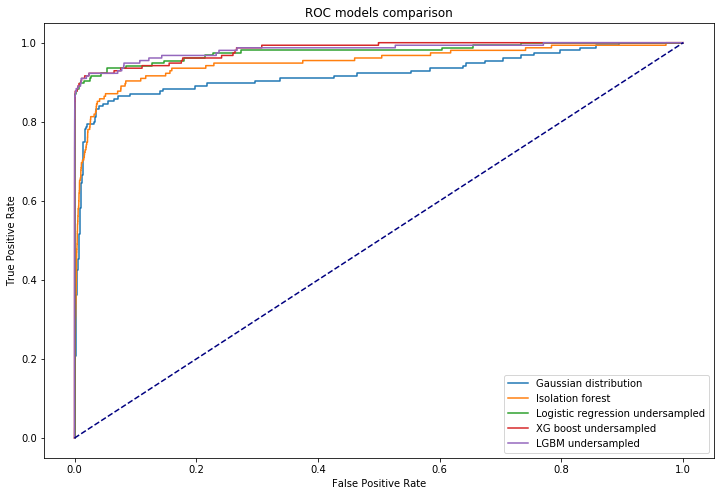

In [243]:
plt.figure(figsize=(12,8))

plt.plot(fpr_G, tpr_G, label='Gaussian distribution')
#plt.plot(fpr_LOF, tpr_LOF, label='Local Outlier Factor')
plt.plot(fpr_IF, tpr_IF, label='Isolation forest')
plt.plot(fpr_lr_u, tpr_lr_u, label='Logistic regression undersampled')
plt.plot(fpr_xg_u, tpr_xg_u, label='XG boost undersampled')
plt.plot(fpr_lg_u, tpr_lg_u, label='LGBM undersampled')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC models comparison')
plt.legend(loc="lower right")
plt.show()

<h2> Recall / Precsion tradeoff

In [394]:
ytest = y_test.values.reshape(-1,1)

In [513]:
precision_lr , recall_lr, threshold_lr = precision_recall_curve(ytest, y_score_lr_u[:,1])
precision_xg_u , recall_xg_u, threshold_xg_u = precision_recall_curve(ytest, y_score_xg_u[:,1])
precision_lg_o , recall_lg_o, threshold_lg_o = precision_recall_curve(ytest, y_score_lg_o[:,1])

In [514]:
precision_g , recall_g, threshold_g = precision_recall_curve(ytest, y_score_g)
precision_if , recall_if, threshold_if = precision_recall_curve(ytest, y_score_if)

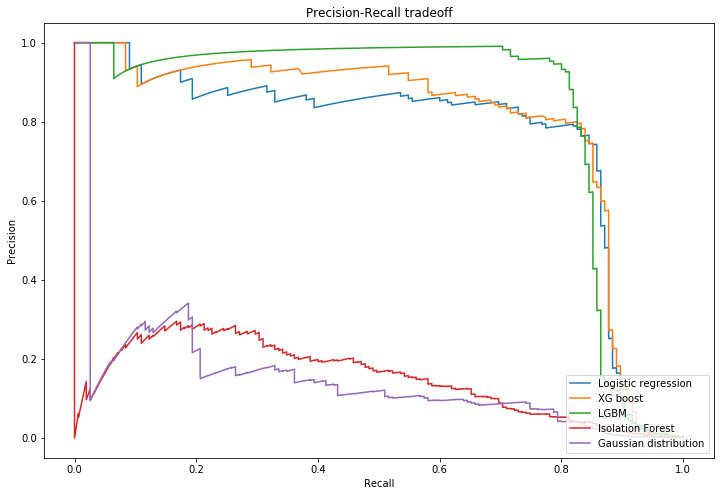

In [515]:
plt.figure(figsize=(12,8))
plt.plot(recall_lr, precision_lr, label="Logistic regression")
plt.plot(recall_xg_u, precision_xg_u, label="XG boost")
plt.plot(recall_lg_o, precision_lg_o, label="LGBM")
plt.plot(recall_if, precision_if, label="Isolation Forest")
plt.plot(recall_g, precision_g, label="Gaussian distribution")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall tradeoff")
plt.legend(loc="lower right")
plt.show()

LGBM seems to be the most adapted model

<h1> Cost functions

<h2> Threshold adjustment

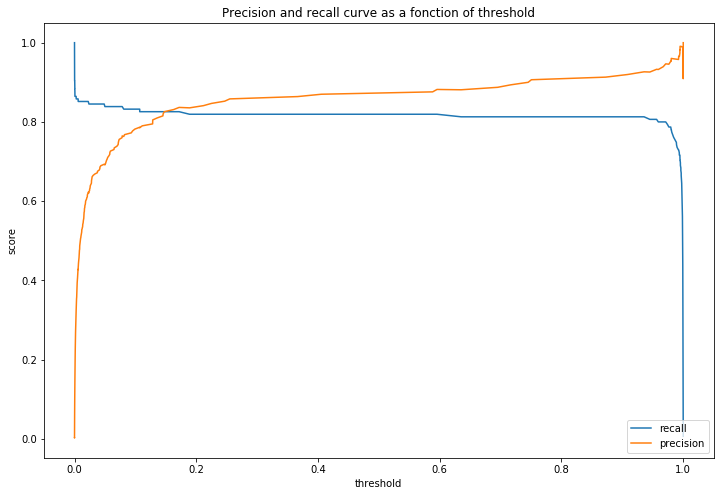

In [516]:
plt.figure(figsize=(12,8))
plt.plot(threshold_lg_o, recall_lg_o[:-1], label="recall")
plt.plot(threshold_lg_o, precision_lg_o[:-1], label="precision")
plt.xlabel('threshold')
plt.ylabel('score')
plt.title("Precision and recall curve as a fonction of threshold")
plt.legend(loc="lower right")
plt.show()

<h2> Cost evaluation

In [474]:
check_cost_u = 2000
additional_cost_u = 10000

In [475]:
threshold = 0.9

In [476]:
def make_prediction(y_score, threshold):
    y_fraud = np.zeros(len(y_score))
    y_fraud[y_score < threshold] = 0
    y_fraud[y_score >= threshold] = 1
    return y_fraud

In [482]:
y_fraud = make_prediction(y_score_lg_u[:,1], threshold=0.5)
len(y_fraud), sum(y_fraud)

(85443, 170.0)

<h3> Cost of fraudulent transaction with algo checking

In [483]:
check_cost = y_fraud.sum() * check_cost_u
check_cost

340000.0

In [484]:
remaining_fraud_cost = X_test["Amount"][y_test-y_fraud == 1].sum()
remaining_fraud_cost

2468.93

In [485]:
additional_cost = len(y_test[y_test-y_fraud == 1]) * additional_cost_u
additional_cost

240000

In [486]:
total_check_cost = check_cost + remaining_fraud_cost + additional_cost
total_check_cost

582468.9299999999

In [487]:
def check_cost(y_pred, check_cost_u, additional_cost_u):
    check_cost = y_pred.sum() * check_cost_u
    remaining_fraud_cost = X_test["Amount"][y_test-y_pred == 1].sum()
    additional_cost = len(y_test[y_test-y_pred == 1]) * additional_cost_u
    return check_cost + remaining_fraud_cost + additional_cost

In [488]:
check_cost(y_fraud, check_cost_u, additional_cost_u)

582468.9299999999

<h3> Cost of fraudulent transaction without algo checking

In [489]:
def actual_cost(additional_cost_u):
    remaining_fraud_cost = X_test["Amount"][y_test == 1].sum()
    additional_cost = len(y_test[y_test == 1]) * additional_cost_u
    return remaining_fraud_cost + additional_cost

In [490]:
actual_cost(additional_cost_u)

1569062.37

<h3> Gain

In [491]:
remaining_fraud_cost = X_test["Amount"][y_test == 1].sum()
remaining_fraud_cost

19062.370000000003

In [492]:
additional_cost = len(y_test[y_test == 1]) * additional_cost_u
additional_cost

1550000

In [493]:
total_actual_cost = remaining_fraud_cost + additional_cost
total_actual_cost

1569062.37

In [494]:
gain = total_actual_cost - total_check_cost
gain

986593.4400000002

In [495]:
def gain(y_score, threshold, check_cost_u=200, additional_cost_u=1000):
    y_pred = make_prediction(y_score, threshold)
    total_check_cost = check_cost(y_pred, check_cost_u, additional_cost_u)
    total_actual_cost = actual_cost(additional_cost_u)
    return total_actual_cost - total_check_cost

In [496]:
gain(y_score_lg_o[:,1], threshold=0.3)

113437.43

In [509]:
thresholds = np.arange(30, 980)/1000

In [510]:
f = lambda t: gain(y_score_lg_o[:,1], t)
gain_lg_o = list(map(f, thresholds))
len(gain_lg_o), max(gain_lg_o)

(950, 114633.67)

<h3> Plot gain function of threshold

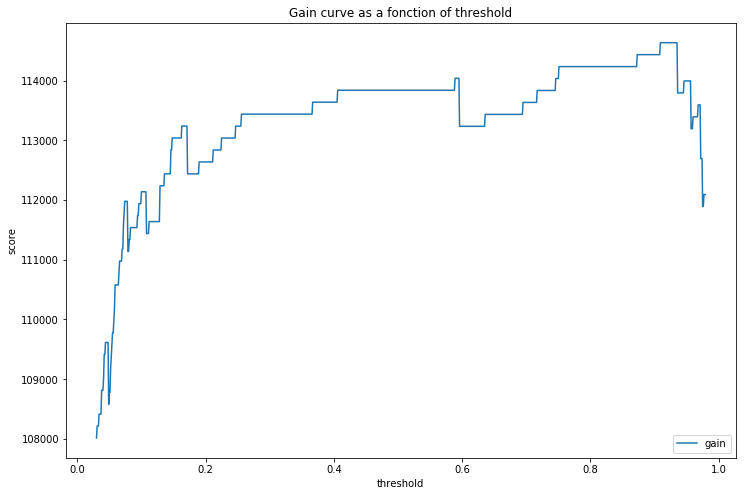

In [511]:
plt.figure(figsize=(12,8))
plt.plot(thresholds, gain_lg_o, label="gain")
plt.xlabel('threshold')
plt.ylabel('score')
plt.title("Gain curve as a fonction of threshold")
plt.legend(loc="lower right")
plt.show()